In [1]:
import numpy as np
import pandas as pd
import glob, os, warnings, shutil, subprocess, re, sys
from Bio import Seq, SeqIO
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import scipy

sys.path.append("/home/sak0914/TRUST_data_processing/scripts")
from utils import *

h37Rv_path = "./H37Rv"
h37Rv_seq = SeqIO.read(os.path.join(h37Rv_path, "GCF_000195955.2_ASM19595v2_genomic.gbff"), "genbank")
h37Rv_genes = pd.read_csv(os.path.join(h37Rv_path, "mycobrowser_h37rv_genes_v4.csv"))

h37Rv_regions = pd.read_csv(os.path.join(h37Rv_path, "mycobrowser_h37rv_v4.csv"))

# these are promoters, transcriptional signals, or RNAs. Exclude these
non_coding_regions = h37Rv_regions.query("Feature != 'CDS'").Name.values

# if these remain in the dataframe, then there will be multiple entires for a single gene name, which will cause process_intergenic_variant_WHO_catalog_coord to fail
h37Rv_regions = h37Rv_regions.query("~Feature.str.contains('|'.join(['promoter', 'signal']), case=False)")
assert len(h37Rv_regions) == h37Rv_regions.Name.nunique()

h37Rv_coords = pd.read_csv(os.path.join(h37Rv_path, "h37Rv_coords_to_gene.csv.gz"), compression='gzip')
h37Rv_coords_dict = dict(zip(h37Rv_coords["pos"].values, h37Rv_coords["region"].values))

# isolates with matched LR sequencing (including samples from the same patient where only 1 sample had LR done)
isolates_with_LR = pd.read_csv("./data/TRUST_isolates_long_read_aln.tsv", sep='\t', header=None)

TRUST_data_dir = "/home/sak0914/TRUST_data_processing/processed_data"
CNN_results_dir = "/n/data1/hms/dbmi/farhat/Sanjana/CNN_results"

silent_lst = ['initiator_codon_variant', 'synonymous_variant', 'stop_retained_variant']

out_dir = "/n/data1/hms/dbmi/farhat/Sanjana/TRUST_lowAF"
F2_thresh = 0.03

# pids to use for Analysis

This includes all patients with longitudinal sampling, regardless of whether or not their lineage designations match.

In [20]:
df_longitudinal_pids = pd.read_csv(f"./data/pids_WGS_data.csv")
df_longitudinal_pids.pid.nunique(), df_longitudinal_pids.SampleID.nunique(), len(df_longitudinal_pids)

(315, 630, 630)

In [79]:
df_longitudinal_pids.query("SampleID=='MFS-742'")

,pid,Original_ID,SampleID,Sampling_Week,Coll2014,Freschi2020,Lipworth2019,Shitikov2017,Stucki2016,F2,Lineage,Paired_Sample_Num,total_samples


In [80]:
df_longitudinal_pids.query("pid=='T0114'")

,pid,Original_ID,SampleID,Sampling_Week,Coll2014,Freschi2020,Lipworth2019,Shitikov2017,Stucki2016,F2,Lineage,Paired_Sample_Num,total_samples
146,T0114,S0114-01,MFS-364,1,4.3.2.1,4.2.1.2.1.1.i1,lam,NaN,4.3/LAM,0.010398,4,1,4
147,T0114,S0114-04,MFS-873,4,4.3.2.1,4.2.1.2.1.1.i1,lam,NaN,4.3/LAM,0.010419,4,2,4


In [21]:
df_longitudinal_pids.Paired_Sample_Num.unique()

array([1, 2])

In [22]:
# HT_regions = find_HT_regions(str(h37Rv_seq.seq))
# HT_regions['Region'] = HT_regions['POS'].map(h37Rv_coords_dict)
HT_regions = pd.read_csv("./data/nucleotide_runs_all_lengths.csv")
print(f"{len(HT_regions)} runs of at least 2")

HT_nucs = []

for i, row in HT_regions.query("Length >= 3").iterrows():
    # don't need to add 1 to the end because the start is one of the N nucleotides
    # BUT add 1 bp to the front and back so that you include variants that occur adjacent to an HT region, not just within it
    HT_nucs += list(np.arange(row['POS'] - 1, row['POS'] - 1 + row['Length'] + 1))

HT_nucs = np.unique(HT_nucs)
print(f"{len(HT_nucs)} nucleotides are in homopolymeric tracts")

880248 runs of at least 2
730854 nucleotides are in homopolymeric tracts


# Distribution of Time Differences between Sampling 1 and 2

In [23]:
sampling_weeks_comparison = df_longitudinal_pids.pivot(index='pid', columns='Paired_Sample_Num', values='Sampling_Week').rename(columns={1: 'Sample1', 2: 'Sample2'}).reset_index()
sampling_weeks_comparison['Diff'] = sampling_weeks_comparison['Sample2'] - sampling_weeks_comparison['Sample1']

In [24]:
sampling_weeks_comparison['Diff'].value_counts().sort_index()

Diff
3    36
4    53
5    60
6    59
7    97
8    10
Name: count, dtype: int64

In [25]:
len(sampling_weeks_comparison), sampling_weeks_comparison['Diff'].mean(), sampling_weeks_comparison['Diff'].median()

(315, 5.501587301587302, 6.0)

# Longitudinal Changes in F2 Score

In [26]:
# Plot the Change in F2 Score between first and second samplings to see if there are any trends
F2_matrix_by_sample = df_longitudinal_pids.pivot(index='pid', columns='Paired_Sample_Num', values='F2').reset_index()
F2_matrix_by_sample.columns = ['pid', 'Sample1', 'Sample2']

In [27]:
def two_WGS_sample_scatterplot(df_plot, title, x_col='Sample1', y_col='Sample2', hue_col=None, F2_thresh=None, color_palette=None, saveName=None):

    df = df_plot.copy()
    
    # add 50% of the second lowest value to 0s. Do this so that they don't just get excluded from the plot. But use the original 0s when computing summary stats and significance
    eps = np.unique(df_plot[[x_col, y_col]], axis=None)[1] * 0.5
    
    df[[x_col, y_col]] = df[[x_col, y_col]].replace(0, eps)

    if hue_col is not None:
        
        sns.scatterplot(data=df,
                        x=x_col,
                        y=y_col,
                        zorder=2,
                        hue=hue_col,
                        hue_order=np.sort(df[hue_col]),
                        palette=color_palette,
                       )
        
    else:
        sns.scatterplot(data=df,
                        x=x_col,
                        y=y_col,
                        zorder=2,
                       )

    line_vals = np.linspace(df[[x_col, y_col]].min(axis=None), df[[x_col, y_col]].max(axis=None))
    
    plt.plot(line_vals, line_vals, color='black', linewidth=1, zorder=1)
    
    if F2_thresh is not None:
        plt.axvline(x=F2_thresh, color='darkred', linestyle='--', zorder=0, linewidth=0.75, label=f'F2 = {F2_thresh}')
        plt.axhline(y=F2_thresh, color='darkred', linestyle='--', zorder=0, linewidth=0.75)
        plt.legend()
    
    plt.xlabel('Sample 1')
    plt.ylabel('Sample 2')
    
    plt.xscale('log')
    plt.yscale('log')
    
    plt.title(f"{title} of {df.pid.nunique()} pids with Longitudinal Sampling")    
    sns.despine()

    if saveName is None:
        plt.show()
    else:
        plt.savefig(saveName, bbox_inches='tight')

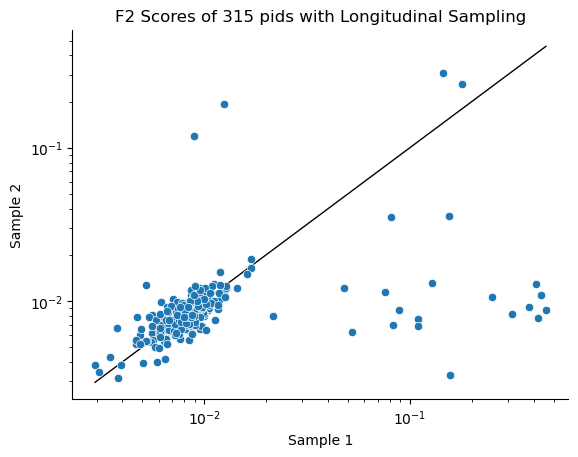

In [28]:
two_WGS_sample_scatterplot(F2_matrix_by_sample, "F2 Scores", F2_thresh=None, saveName="./results/figures/F2_longitudinal.svg")

In [29]:
st.ttest_rel(np.log(F2_matrix_by_sample['Sample1']),
             np.log(F2_matrix_by_sample['Sample2']),
             alternative='greater',
           )

TtestResult(statistic=3.036321900408923, pvalue=0.001297709384997415, df=314)

In [30]:
F2_matrix_by_sample.query("Sample1 < 0.1 & Sample2 > 0.1")

,pid,Sample1,Sample2
147,T0224,0.012427,0.193040
153,T0235,0.008906,0.118415


# Associate F2 with Disease Burden at Baseline:

<ul>
    <li>TTP</li>
    <li>Predicted PLI</li>
</ul>

In [63]:
df_trust_patients = pd.read_csv(f"{TRUST_data_dir}/20250818_combined_patient_WGS_data.csv")

for col in df_trust_patients:
    if col in df_longitudinal_pids.columns and col not in ['pid', 'SampleID', 'Original_ID']:
        del df_trust_patients[col]

df_trust_patients = df_trust_patients.merge(df_longitudinal_pids, on=['pid', 'SampleID', 'Original_ID'])
PLI_Timika_predictions = pd.read_csv(f"{TRUST_data_dir}/PLI_Timika_predictions.csv").merge(df_longitudinal_pids, on='pid').drop_duplicates(subset='pid', keep='first')

df_TTP_smear = pd.read_csv(f"{TRUST_data_dir}/TTP_smear_results.csv")
df_TCC = pd.read_csv(f"{TRUST_data_dir}/imputed_TCC.csv")
# df_final_outcomes = pd.read_csv(f"{TRUST_data_dir}/tx_outcomes.csv")

print(f"{df_TTP_smear.dropna(subset='culture_sample_num').query('culture_sample_num <= 2').pid.nunique()} pids with baseline TTPs within the first 2 weeks")

df_pids_valid_smear_TTP = df_TTP_smear.query("culture_sample_num <= 2").merge(df_longitudinal_pids, on='pid')
print(f"{df_pids_valid_smear_TTP.pid.nunique()} pids have valid TTP and smear at baseline")

# save a dataframe of just the first sample for each pid
df_baseline_pids_valid_smear_TTP = df_pids_valid_smear_TTP.query("Paired_Sample_Num == 1").reset_index(drop=True)

403 pids with baseline TTPs within the first 2 weeks
310 pids have valid TTP and smear at baseline


In [50]:
# patients with the first culture taken after week 2. Exclude just for this association
# df_TTP_smear.query("pid not in @df_pids_valid_smear_TTP.pid & pid in @df_longitudinal_pids.pid")

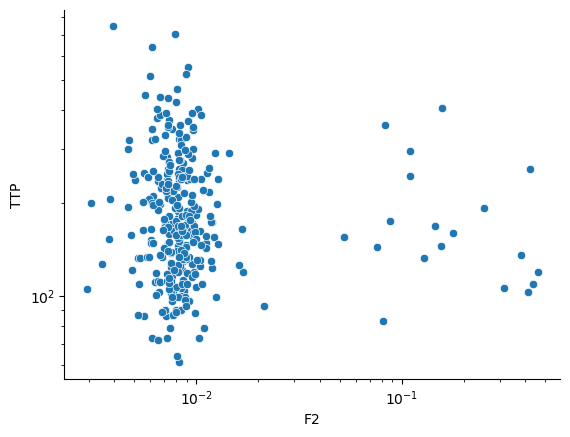

In [75]:
sns.scatterplot(data=df_baseline_pids_valid_smear_TTP,
                x='F2',
                y='TTP'
               )

plt.xscale('log')
plt.yscale('log')

sns.despine()
plt.show()

In [42]:
st.spearmanr(df_baseline_pids_valid_smear_TTP['F2'],
             df_baseline_pids_valid_smear_TTP['TTP']
            )

SignificanceResult(statistic=-0.07199146423867359, pvalue=0.20620823182830914)

In [ ]:
df_baseline_pids_valid_smear_TTP.groupby('Lineage')['TTP'].mean()

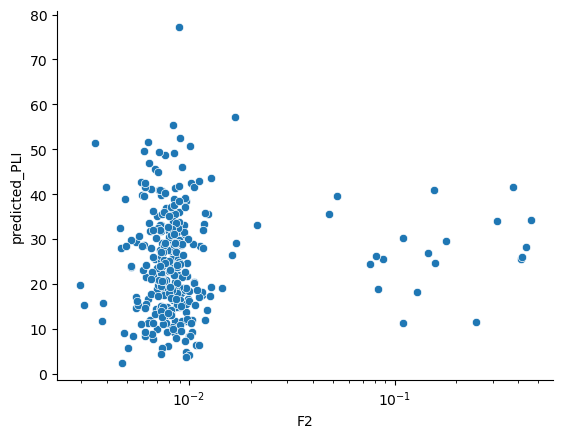

In [77]:
sns.scatterplot(data=PLI_Timika_predictions,
                x='F2',
                y='predicted_PLI'
               )

plt.xscale('log')
# plt.yscale('log')

sns.despine()
plt.show()

In [69]:
st.spearmanr(PLI_Timika_predictions['F2'],
             PLI_Timika_predictions['predicted_PLI']
            )

SignificanceResult(statistic=0.019158762931783424, pvalue=0.7356435619949762)

In [71]:
PLI_Timika_predictions.groupby('Lineage')['predicted_PLI'].mean()

Lineage
2      24.822115
2,4    34.687538
3      23.040998
4      25.098935
Name: predicted_PLI, dtype: float64

In [72]:
PLI_Timika_predictions.query("Lineage=='2,4'")

,pid,View,Outlier,predicted_PLI,predicted_Timika_Score,Original_ID,SampleID,Sampling_Week,Coll2014,Freschi2020,Lipworth2019,Shitikov2017,Stucki2016,F2,Lineage,Paired_Sample_Num,total_samples
10,T0010,1B,0,34.219090,48.280827,S0010-01,MFS-336,1,"4.1.1.1,2.2.1.1","4.1.i1.2.1,2.2.1.1.1","beijing,xtype,westafrican1","lin2.2.1,pacific_RD150",NaN,0.459022,"2,4",1,2
398,T0305,1B,1,28.317162,38.619675,S0305-01,MFS-313,1,"4.3.2.1,2.2.1.1","2.2.1.1.1,4.2.1.2.1.1.i1","beijing,lam","lin2.2.1,pacific_RD150",4.3/LAM,0.435704,"2,4",1,2
404,T0311,1B,0,41.526363,54.280132,S0311-01,MFS-317,1,"4.3.2.1,2.2.1.1","2.2.1.1.1,4.2.1.2.1.1.i1","beijing,lam","lin2.2.1,pacific_RD150",4.3/LAM,0.378468,"2,4",1,2


# Fixed Phase Variants present in ≥90% of Samples. Are these suspicious?

In [96]:
data_dir = "./results/full_genome"

df_phase_variants = pd.concat([pd.read_csv(f"{data_dir}/fixed_variants.csv")]).query("POS in @HT_nucs")#.query("Phase_Variant==1")
    
# exclude variants in regions that are RNAs, promoters, or transcriptional signals. So exclude defined annotations that are non-coding
# NOTE THAT THIS DOES NOT EXCLUDE INTERGENIC REGIONS
df_phase_variants = df_phase_variants.query("GENE not in @non_coding_regions").reset_index(drop=True)
print(df_phase_variants.SampleID.nunique())

174


In [101]:
df_phase_variants

,SampleID,POS,REF,ALT,QUAL,DP,DPB,RO,AO,AF,...,RPPR,RPL,RPR,ANN,GENE,EFFECT,HGVS_C,HGVS_P,SRP_prob,SAP_prob
0,MFS-162,14861,G,T,8142.16,268,268.000,0,268.0,1.000000,...,0.00000,111.0,157.0,['T|missense_variant|MODERATE|Rv0012|Rv0012|tr...,Rv0012,missense_variant,c.773G>T,p.Gly258Val,NaN,0.414901
1,MFS-162,44768,A,G,8189.35,272,272.000,1,270.0,0.992647,...,5.18177,121.0,149.0,['G|missense_variant|MODERATE|leuS|Rv0041|tran...,leuS,missense_variant,c.1207A>G,p.Arg403Gly,NaN,0.485402
2,MFS-162,49690,GCC,G,7132.11,236,157.833,0,235.0,0.995763,...,0.00000,121.0,114.0,['G|frameshift_variant|HIGH|Rv0045c|Rv0045c|tr...,Rv0045c,frameshift_variant,c.248_249delGG,p.Gly83fs,NaN,0.132267
3,MFS-162,52209,C,G,9085.24,300,300.000,0,300.0,1.000000,...,0.00000,161.0,139.0,['G|missense_variant|MODERATE|Rv0048c|Rv0048c|...,Rv0048c,missense_variant,c.489G>C,p.Met163Ile,NaN,0.162056
4,MFS-162,62049,A,G,8334.65,274,274.000,0,274.0,1.000000,...,0.00000,129.0,145.0,['G|missense_variant|MODERATE|dnaB|Rv0058|tran...,dnaB,missense_variant,c.1654A>G,p.Arg552Gly,NaN,0.416600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21983,MFS-276,4379044,CG,C,5323.36,179,157.750,1,177.0,0.988827,...,5.18177,67.0,110.0,['C|frameshift_variant|HIGH|eccC2|Rv3894c|tran...,eccC2,frameshift_variant,c.1408delC,p.Arg470fs,NaN,0.498589
21984,MFS-276,4383144,C,CCGGGG,5137.17,173,344.000,0,170.0,0.982659,...,0.00000,79.0,91.0,['CCGGGG|frameshift_variant|HIGH|Rv3897c|Rv389...,Rv3897c,frameshift_variant,c.496_497insCCCCG,p.Gly166fs,NaN,0.494153
21985,MFS-276,4384127,A,G,8574.81,282,282.000,0,282.0,1.000000,...,0.00000,143.0,139.0,['G|intergenic_region|MODIFIER|Rv3898c-Rv3899c...,Rv3898c-Rv3899c,intergenic_region,n.4384127A>G,NaN,NaN,0.469082
21986,MFS-276,4400660,AC,A,4257.38,141,121.571,0,141.0,1.000000,...,0.00000,86.0,55.0,['A|frameshift_variant|HIGH|sigM|Rv3911|transc...,sigM,frameshift_variant,c.478delC,p.Arg160fs,NaN,0.325555


In [98]:
variants_found_in_most_samples = []
variant_thresh = 0.9

for variant in df_phase_variants.variant.unique():
    
    if df_phase_variants.query("variant==@variant").SampleID.nunique() / df_phase_variants.SampleID.nunique() >= variant_thresh:
        variants_found_in_most_samples.append(variant)
        
print(f"{len(variants_found_in_most_samples)}/{df_phase_variants.variant.nunique()} variants are found in at least {variant_thresh*100}% of samples")

AttributeError: 'DataFrame' object has no attribute 'variant'

In [11]:
variants_found_in_most_samples = []
variant_thresh = 0.9

for variant in df_phase_variants.variant.unique():
    
    if df_phase_variants.query("variant==@variant").SampleID.nunique() / df_phase_variants.SampleID.nunique() >= variant_thresh:
        variants_found_in_most_samples.append(variant)
        
print(f"{len(variants_found_in_most_samples)}/{df_phase_variants.variant.nunique()} variants are found in at least {variant_thresh*100}% of samples")

9/268 variants are found in at least 90.0% of samples


# Longitudinal Changes in Number of Fixed Variants

In [ ]:
df_fixed_variants = pd.read_csv("./results/full_genome/fixed_variants.csv").merge(df_longitudinal_pids[['pid', 'SampleID', 'F2', 'Coll2014', 'Lineage', 'Sampling_Week', 'Paired_Sample_Num']], on='SampleID')

df_fixed_variants['Lineage'] = df_fixed_variants['Lineage'].astype(str)

print(len(df_fixed_variants), df_fixed_variants.pid.nunique(), df_fixed_variants.SampleID.nunique())

91603 82 144


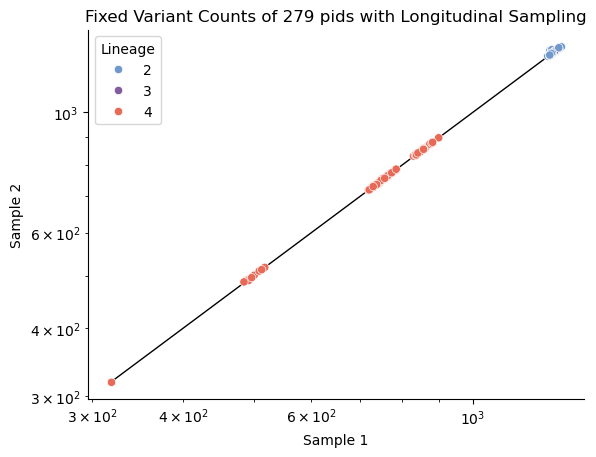

In [98]:
LinToColor_Dict = {"1": "#DF83AC",
                   "2": "#7098CB",
                   "3": "#815D9F",
                   "4": "#E76956",
                   "Other": "white"
                   # "5": "#B67548",
                   # "6": "#6AB79E",
                   # "8": "#E4515B",
                   # "M.bovis": "white",
                  }

df_fixed_variant_counts = pd.DataFrame(df_fixed_variants.query("Paired_Sample_Num <= 2").groupby(['pid', 'SampleID', 'Paired_Sample_Num', 'F2'])['variant'].count().sort_values()).reset_index()

# dropna to drop patients with F2 below the threshold for only one sample
df_fixed_variant_counts = df_fixed_variant_counts.query("F2 <= @F2_thresh").pivot(index='pid', columns='Paired_Sample_Num', values='variant').reset_index().dropna()

# rename columns for readability
df_fixed_variant_counts.rename(columns={1: 'Sample1', 2: 'Sample2'}, inplace=True)

# add lineage back to the dataframe
df_fixed_variant_counts = df_fixed_variant_counts.merge(df_fixed_variants[['pid', 'Lineage']].drop_duplicates(), on='pid', how='left')

two_WGS_sample_scatterplot(df_fixed_variant_counts, 
                           f"Fixed Variant Counts", 
                           F2_thresh=None, 
                           hue_col='Lineage', 
                           color_palette=LinToColor_Dict, 
                           saveName="./results/figures/fixed_variants_longitudinal_unmixed.svg"
                          )

In [91]:
st.wilcoxon(df_fixed_variant_counts['Sample1'],
             df_fixed_variant_counts['Sample2'],
             alternative='two-sided'
            )

WilcoxonResult(statistic=10931.0, pvalue=0.22543847957706908)

In [92]:
st.spearmanr(df_fixed_variant_counts['Sample1'], df_fixed_variant_counts['Sample2'])

SignificanceResult(statistic=0.983204264202183, pvalue=1.1562948678852482e-206)

In [103]:
df_fixed_variant_counts[['Sample1', 'Sample2']].max()

Sample1    1324.0
Sample2    1321.0
dtype: float64

In [106]:
df_fixed_variant_counts.sort_values('Sample1', ascending=False).head()

,pid,Sample1,Sample2,Lineage
46,T0067,1324.0,1321.0,2
31,T0046,1316.0,1316.0,2
197,T0335,1314.0,1309.0,2
1,T0003,1313.0,1316.0,2
273,T0470,1313.0,1316.0,2


# Longitudinal Changes in Unfixed Variants

In [109]:
# df_all_unfixed_variants = []

# for i, sample in enumerate(df_trust_patients.SampleID.unique()):
    
#     df_variants = get_unfixed_variants(f"{out_dir}/{sample}/freebayes/{sample}.csv", df_trust_patients)
    
#     df_all_unfixed_variants.append(df_variants)
    
#     if i % 100 == 0:
#         print(i)
    
# df_all_unfixed_variants = pd.concat(df_all_unfixed_variants).reset_index(drop=True)

# df_all_unfixed_variants['Lineage'] = df_all_unfixed_variants['Lineage'].astype(str)

# df_all_unfixed_variants.to_csv("./processed_data/full_genome/unfixed_variants.csv", index=False)

df_all_unfixed_variants = pd.read_csv("./processed_data/full_genome/unfixed_variants.csv").merge(df_longitudinal_pids[['SampleID', 'F2', 'Coll2014', 'Lineage', 'Sampling_Week', 'Paired_Sample_Num']], on='SampleID')

df_all_unfixed_variants['Lineage'] = df_all_unfixed_variants['Lineage'].astype(str)

print(len(df_all_unfixed_variants), df_all_unfixed_variants.pid.nunique(), df_all_unfixed_variants.SampleID.nunique())

18597 301 600


In [110]:
df_all_unfixed_variants.query("SAP_prob <= 0.05")[['pid', 'SampleID', 'POS', 'REF', 'ALT', 'AF', 'SAF', 'SAR', 'SAP_prob', 'Phase_Variant', 'F2']].query("Phase_Variant==1 & F2 <= 0.03")

,pid,SampleID,POS,REF,ALT,AF,SAF,SAR,SAP_prob,Phase_Variant,F2
3983,T0111,MFS-362,850595,C,CT,0.180645,4.0,24.0,0.000395,1,0.008438
3991,T0111,MFS-363,850595,C,CT,0.155844,4.0,20.0,0.002414,1,0.006698
4177,T0116,MFS-578,381842,G,GC,0.165877,11.0,24.0,0.044716,1,0.006285
6278,T0187,MFS-626,1826288,GA,G,0.293333,18.0,48.0,0.000547,1,0.005495
10127,T0245,MFS-157,3717127,G,GC,0.655914,43.0,79.0,0.002467,1,0.008931
14621,T0324,MFS-388,4274157,T,TG,0.162562,23.0,10.0,0.038629,1,0.008933
14942,T0351,MFS-430,3010354,T,TG,0.416667,44.0,76.0,0.007014,1,0.004914
14984,T0355,MFS-437,854252,G,GC,0.068592,4.0,15.0,0.020705,1,0.005776
18386,T0459,MFS-839,4277509,G,GC,0.642691,169.0,108.0,0.000605,1,0.007430
18542,T0471,MFS-861,987585,A,AG,0.660550,127.0,89.0,0.017673,1,0.007856


# Compute Unfixed:Fixed SNP Ratio

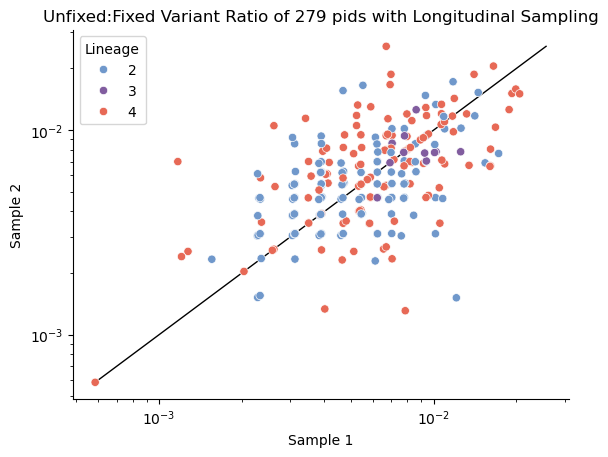

In [112]:
LinToColor_Dict = {"1": "#DF83AC",
                   "2": "#7098CB",
                   "3": "#815D9F",
                   "4": "#E76956",
                   "Other": "white"
                   # "5": "#B67548",
                   # "6": "#6AB79E",
                   # "8": "#E4515B",
                   # "M.bovis": "white",
                  }

df_unfixed_variant_counts = pd.DataFrame(df_all_unfixed_variants.query("Paired_Sample_Num <= 2").groupby(['pid', 'SampleID', 'Paired_Sample_Num', 'F2', 'Lineage'])['variant'].count().sort_values()).reset_index()

# dropna to drop patients with F2 below the threshold for only one sample
df_unfixed_variant_counts = df_unfixed_variant_counts.query("F2 <= @F2_thresh").pivot(index='pid', columns='Paired_Sample_Num', values='variant').reset_index().dropna()

# rename columns for readability
df_unfixed_variant_counts.rename(columns={1: 'Sample1', 2: 'Sample2'}, inplace=True)

# add lineage back to the dataframe
df_unfixed_variant_counts = df_unfixed_variant_counts.merge(df_all_unfixed_variants[['pid', 'Lineage']].drop_duplicates(), on='pid', how='left')

# add fixed counts in order to compute the unfixed:fixed ratio
df_unfixed_variant_counts = df_unfixed_variant_counts.merge(df_fixed_variant_counts.rename(columns={'Sample1': 'Sample1_Fixed', 'Sample2': 'Sample2_Fixed'}), how='outer', on=['pid', 'Lineage'])

# fill empty unfixed variant counts with 0
df_unfixed_variant_counts[['Sample1', 'Sample2']] = df_unfixed_variant_counts[['Sample1', 'Sample2']].fillna(0).astype(int)

# compute ratio
df_unfixed_variant_counts['Sample1_Unfixed_Fixed_Ratio'] = df_unfixed_variant_counts['Sample1'] / df_unfixed_variant_counts['Sample1_Fixed']
df_unfixed_variant_counts['Sample2_Unfixed_Fixed_Ratio'] = df_unfixed_variant_counts['Sample2'] / df_unfixed_variant_counts['Sample2_Fixed']

two_WGS_sample_scatterplot(df_unfixed_variant_counts, 
                           f"Unfixed:Fixed Variant Ratio", 
                           x_col='Sample1_Unfixed_Fixed_Ratio',
                           y_col='Sample2_Unfixed_Fixed_Ratio',
                           F2_thresh=None, 
                           hue_col='Lineage', 
                           color_palette=LinToColor_Dict, 
                           saveName="./results/figures/unfixed_fixed_ratio_unmixed.svg"
                          )


In [113]:
st.wilcoxon(df_unfixed_variant_counts['Sample1_Unfixed_Fixed_Ratio'],
            df_unfixed_variant_counts['Sample2_Unfixed_Fixed_Ratio'],
            alternative='two-sided'
           )

WilcoxonResult(statistic=16023.0, pvalue=0.2796128944960482)

In [114]:
st.spearmanr(df_unfixed_variant_counts['Sample1_Unfixed_Fixed_Ratio'],
            df_unfixed_variant_counts['Sample2_Unfixed_Fixed_Ratio'],
           )

SignificanceResult(statistic=0.5515492635631674, pvalue=1.314486905803693e-23)

# Total Number of Unfixed Variants by F2

In [115]:
df_unfixed_long = pd.DataFrame(df_all_unfixed_variants.groupby(['pid', 'SampleID', 'Paired_Sample_Num', 'F2', 'Lineage'])['variant'].count().sort_values()).reset_index()
df_fixed_long = pd.DataFrame(df_fixed_variants.groupby(['pid', 'SampleID', 'Paired_Sample_Num', 'F2', 'Lineage'])['variant'].count().sort_values()).reset_index()

df_unfixed_long = df_unfixed_long.merge(df_fixed_long[['pid', 'SampleID']], how='right')
df_unfixed_long['variant'] = df_unfixed_long['variant'].fillna(0).astype(int)

df_unfixed_long['high_F2'] = (df_unfixed_long['F2'] > 0.03).astype(int)

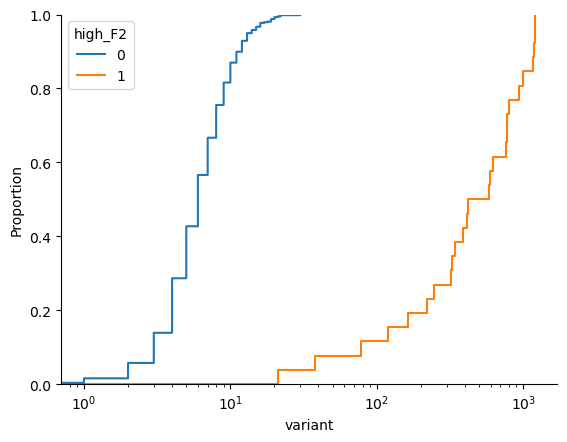

In [102]:
sns.ecdfplot(data=df_unfixed_long,
             x='variant',
             hue='high_F2',
             # multiple='dodge',
             # common_norm=False,
             # stat='probability'
            )

plt.xscale('log')
sns.despine()
plt.show()

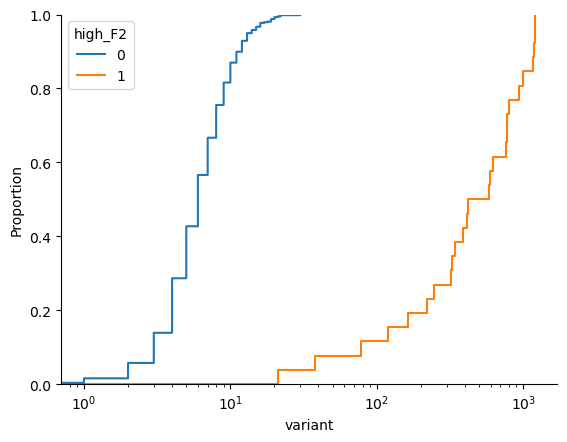

In [116]:
sns.ecdfplot(data=df_unfixed_long,
             x='variant',
             hue='high_F2',
             # multiple='dodge',
             # common_norm=False,
             # stat='probability'
            )

plt.xscale('log')
sns.despine()
plt.show()

# Plot Unfixed:Fixed Variant Ratio vs. F2 to see if most of the unfixed:fixed variant ratios are explained by F2

In [117]:
df_unfixed_variant_counts = pd.DataFrame(df_all_unfixed_variants.groupby(['pid', 'SampleID', 'Paired_Sample_Num', 'F2', 'Lineage'])['variant'].count().sort_values()).reset_index()
df_fixed_variant_counts = pd.DataFrame(df_fixed_variants.groupby(['pid', 'SampleID', 'Paired_Sample_Num', 'F2', 'Lineage'])['variant'].count().sort_values()).reset_index()

df_combined = df_fixed_variant_counts.rename(columns={'variant': 'count_fixed'}).merge(df_unfixed_variant_counts[['pid', 'SampleID', 'variant']].rename(columns={'variant': 'count_unfixed'}), how='outer', on=['pid', 'SampleID'])
df_combined['count_unfixed'] = df_combined['count_unfixed'].fillna(0).astype(int)

df_combined['unfixed_fixed_ratio'] = df_combined['count_unfixed'] / df_combined['count_fixed']

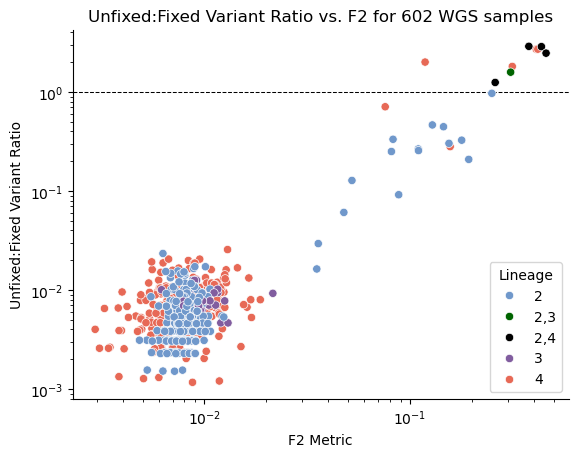

In [126]:
LinToColor_Dict = {"1": "#DF83AC",
                   "2": "#7098CB",
                   "3": "#815D9F",
                   "4": "#E76956",
                   "2,3": "darkgreen",
                   "2,4": "black"
                  }

sns.scatterplot(data=df_combined,
                x='F2',
                y='unfixed_fixed_ratio',
                hue='Lineage',
                hue_order=np.sort(df_combined['Lineage']),
                palette=LinToColor_Dict
               )

plt.axhline(y=1, linestyle='--', color='black', zorder=0, linewidth=0.75)

plt.xscale('log')
plt.yscale('log')

plt.ylabel('Unfixed:Fixed Variant Ratio')
plt.xlabel('F2 Metric')

plt.title(f"Unfixed:Fixed Variant Ratio vs. F2 for {df_combined.SampleID.nunique()} WGS samples")

sns.despine()
plt.savefig("./results/figures/unfixed_fixed_ratio_vs_F2.svg")

In [129]:
st.spearmanr(df_combined.query("F2 > 0.03")['F2'], df_combined.query("F2 > 0.03")['unfixed_fixed_ratio'])

SignificanceResult(statistic=0.8302274014313112, pvalue=1.546447724985225e-07)

In [130]:
st.pearsonr(np.log(df_combined.query("F2 > 0.03")['F2']), np.log(df_combined.query("F2 > 0.03")['unfixed_fixed_ratio']))

PearsonRResult(statistic=0.8894332720848167, pvalue=1.2398179001187487e-09)

In [131]:
len(df_combined.query("F2 > 0.03"))

26

# Correlate F2 Score with Disease Burden

82 patients share a household with another patient, accounting for 32 households
402 unique households across 452 patients
418 patients with any WGS samples
418 patients with uncontaminated WGS samples
3 patients: ['T0137' 'T0395' 'T0402'] have multiple sequences at the same timepoint
Removing 1 patients: ['T0402'] because there are multiple WGS samples at the same timepoint with different lineages
743 patients have MICs for RIF
743 patients have MICs for INH
743 patients have MICs for EMB
533 patients have MICs for PZA
416 patients have measured MICs

Found predicted RIF MICs for 417 pids
Found predicted INH MICs for 417 pids
Found predicted EMB MICs for 417 pids
Found predicted PZA MICs for 417 pids
417 patients have predicted MICs
73 patients share a household with another patient, accounting for 31 households
375 unique households across 417 patients
386/417 patients with valid TCC, WGS, and MICs


In [140]:
df_trust_patients.query("pid in @df_longitudinal_pids.pid").pid.nunique()

301

In [134]:
df_TTP_smear, df_TCC, df_combined_culture_results = get_combined_culture_results(df_trust_patients)
print(f"{df_TCC.pid.nunique()} pids for the TCC analysis")
print(f"{df_TTP_smear.dropna(subset='culture_sample_num').query('culture_sample_num <= 5').pid.nunique()} pids with baseline TTPs within the first 5 weeks")

386 pids for the TCC analysis
404 pids with baseline TTPs within the first 5 weeks


In [157]:
df_TTP_smear = df_TTP_smear.merge(df_longitudinal_pids, how='right')

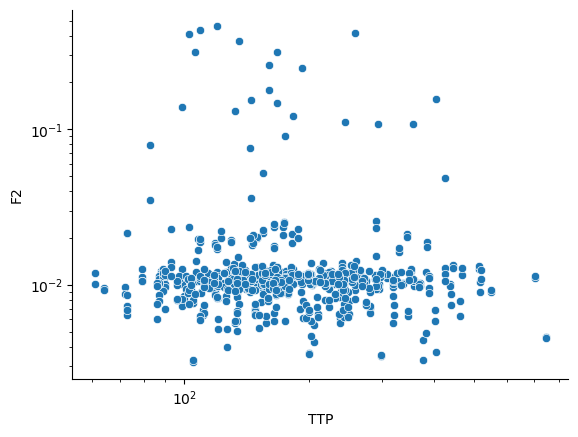

In [161]:
sns.scatterplot(data=df_TTP_smear,
                x='TTP',
                y='F2'
               )

plt.xscale('log')
plt.yscale('log')

sns.despine()
plt.show()

In [163]:
st.spearmanr(df_TTP_smear['F2'], df_TTP_smear['TTP'])

SignificanceResult(statistic=-0.018431810170293467, pvalue=0.6517477177537888)

In [165]:
df_TTP_smear.groupby('smear_grade')['F2'].mean()

smear_grade
0.0    0.016297
1.0    0.021562
2.0    0.017413
3.0    0.015668
4.0    0.019680
Name: F2, dtype: float64